<h1 style='color:white; background:orange; border:0'>ColorMatch Clustering - by Kay Delventhal</center></h1>

### Capstone Project: Product Clustering

Coauthors: Elias Büchner, Kay Delventhal, Niels-Christian Leight and Phillip McRae

<h2 style='color:white; background:orange; border:0'>Classify images by color clustering for feature creation.</center></h2>

This Notebook is based on Python 3.6 - for the benefit of GPU processing.

### The Idea:

In research for image embbedings, historgrams were described as a limited solution. Nevertheless, using clustering to create a color profile that could be used to determine a distance to more or less similar images, seemed to be a potential solution for our problem: https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/word

Similar to algorithms like pHash, images are pre-processed to engineer new features for classification or clustering. To achieve this goal, the color histograms of the images in the datset will be clustered using k-Means, with varrying cluster sizes. These clusters will give us a number of P-values and colors (RGB) representing the mean values of similar pixels in the image. 

**The hypothesis would be: A list of these P(RGB) mean values is similar if the images are similar.**

A distance function can be used to obtain a similarity ranking. That allows to set a threshold in order to cluster images.

Different colorspaces are analysed:
- **RGB, HSV, LAB**

Different k-Means cluster sizes where used:
- **4, 8, 16, 32**

Research showed that for color separation the LAB colorspace seems to have the best **Delta-E** aka **Color Difference**: https://en.wikipedia.org/wiki/Color_difference 

### Note:

For this notebook the following data is needed:
- shopee-product-matching/train_images
- shopee-product-matching/test_images
- train.csv
- test.csv
- sample_submission.csv

For this notebook the following python files are needed:
- ColorMatch.py
- CSData.py
- CSScoring.py
- CSTools.py

### Python Setup

In [2]:
# basic python module import
from glob import glob
from time import time
from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

### Project Tools and Environment Setup

In [256]:
# python module import - cgn-data-21-1 Capstone Project tools
import os
import importlib # to reload modules

import CSTools as ct
importlib.reload(ct)

import CSData as cd
importlib.reload(cd)

import CSScoring as sc
importlib.reload(sc)

import ColorMatch as cm
importlib.reload(cm)

# base path setup
PATH = os.getcwd().replace('\\','/')+'/'
print(PATH)
DATA = PATH+'ColorMatch'+'/'
if not os.path.isdir(DATA):
    os.makedirs(DATA)
print(PATH)
print(DATA)

# cgn-data-21-1 Capstone Project tools
dict_setup = cd.my_setup(work_path=PATH+'output',
                input_path_train_image = PATH+'shopee-product-matching/train_images' , 
                input_path_test_image  = PATH+'shopee-product-matching/test_images' ,
                input_path_train_csv   = PATH+'shopee-product-matching/train.csv',
                input_path_test_csv    = PATH+'shopee-product-matching/test.csv',
                input_path_sasu_csv    = PATH+'shopee-product-matching/sample_submission.csv')
# save dataframe in dict and target
dict_begin = cd.my_begin(dict_setup)

D:/_DataScience/CapstoneProject/
D:/_DataScience/CapstoneProject/
D:/_DataScience/CapstoneProject/ColorMatch/


## k-Means Color Clustering

### k-Means cluster with k = 4

0.515825 [253.4351071  247.80764757 251.70732771]
0.29675 [201.26347658 141.3716256  157.88705744]
0.115925 [113.74421121  91.07595758  97.47262497]
0.0715 [23.60476524 21.71058164 22.43693062]


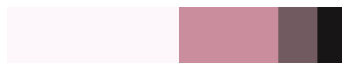

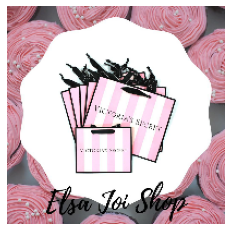

In [19]:
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)
# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()
# show our image
plt.figure()
plt.axis("off")
plt.imshow(image)
plt.show()

### k-Means cluster with k = 8

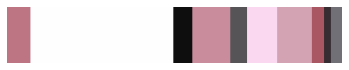

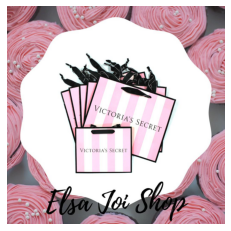

In [39]:
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)
# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()
# show our image
plt.figure()
plt.axis("off")
plt.imshow(image)
plt.show()

### k-Means clustering with different parameters: k = 4, 8, 16, 32

All 32412 images of all 34250 'posting_id', for all 11014 'label_group' were clustered.

In [262]:
# define global vars for image and label data
SHOPEEIMG_TRAIN = PATH+'shopee-product-matching/train_images'
# get filenames and paths from data folder
images = [x.replace('\\','/') for x in glob(SHOPEEIMG_TRAIN+'/*.jpg')]
print('images:', len(images))

# define number of clusters for k-Means
CLUSTER = 32
cm.KMeans_clustering(dict_begin,images,SHOPEEIMG_TRAIN,DATA,CLUSTER,)

## Feature Engineering

After the k-Means clustering the generated P(RGB) parameter lists were transformed into an array. Also the colors were transformed into different colorspaces: **RGB, HSV and LAB**

In [33]:
all_data = dict()
STOP=35000

EXT     = '16'
VER     = '16'
BOOSTER = 5
SCALE   = 1.0
CHOP    = (0,-1)

img_hist_lst = ct.read_dict('img_hist_lst_'+VER,DATA)
data, stats = cm.gen_feature_vec(dict_begin,
                                 img_hist_lst,
                                 booster=BOOSTER,
                                 ext=EXT,
                                 scale=SCALE,
                                 chop=CHOP,
                                 stop=STOP)
name = str(VER)+str(BOOSTER)+str(EXT)
all_data[name] = [data, stats]
print(name)

ct.write_dict("all_data_20210425_16",all_data,DATA)

This was done with many different hyper parmeter:

- VER     = Cluster size used for k-Means clustering
- BOOSTER = The 'BOOSTER' would apply a gausian 'smear' effect, which would 'bleed' the single color values into each other
- SCALE   = Allows to add an additianol scale to the P-value
- CHOP    = Would cut the first and last parameter off the k-Means cluster

## Calculate Color Distance:  Delta-E

In [261]:
# The color distance Delta-E is define in: https://en.wikipedia.org/wiki/Color_difference
def dist_func_vec3(A1, B1, A2, B2, A3, B3):
    return np.sqrt(np.sum(np.square(A1 - B1)) + 
                   np.sum(np.square(A2 - B2)) + 
                   np.sum(np.square(A3 - B3)))

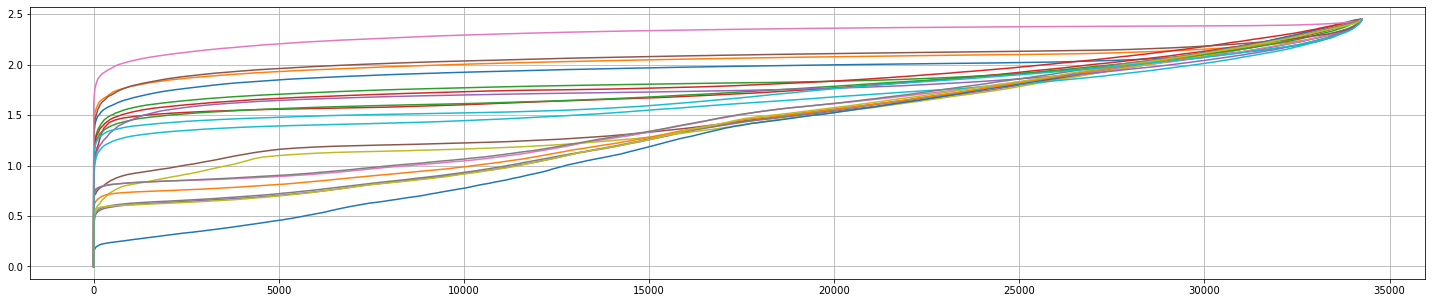

In [52]:
fig, (ax1) = plt.subplots(1, 1, figsize=(25,5))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
for k, i in plt_dat.items():
    #ax1.plot(i[:samples])
    #ax1.plot(i/i[-1])
    ax1.plot(i)
ax1.grid(True)
#ax1.set_xlim(0, samples)
#ax1.set_ylim(0, 1.5)
plt.show()

This plot shows **n-to-all** graphs and it is visible that the color distance is a value between 0 and 2.5 and spreads over the whole distance of all neighbours.

In order to apply some kind of threshold, the values need to be **normalized**.

### Thresholds need normalizing

In order to apply a normalization which is usable with a threshold, each curves need to normalized with individual values.

The values are obtained from the curve itself, at some sample point. The first graph shows normalization with **sample = 100**. The second graph shows normalization with **sample = 25** 

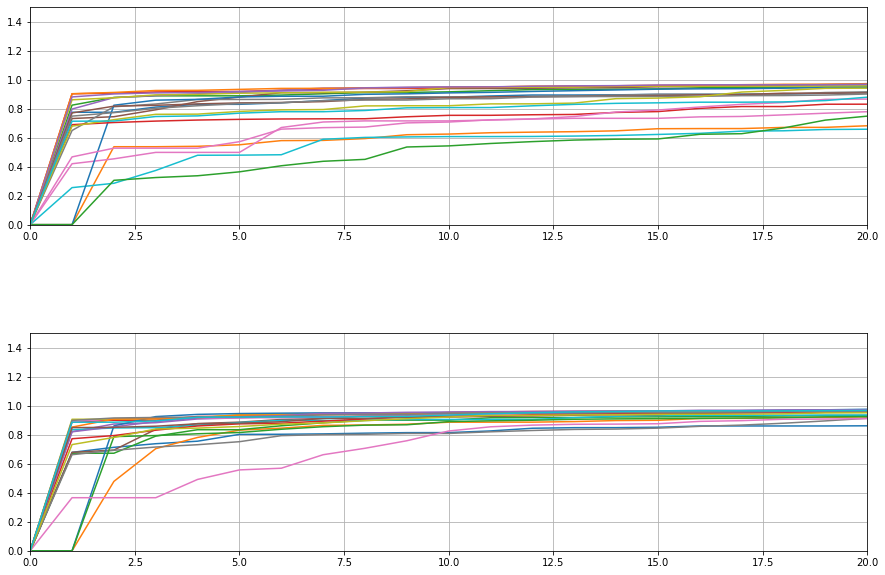

In [23]:
import numpy as np
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

for k, i in a_fig.items():
    ax1.plot(i/i[-1])
ax1.grid(True)
ax1.set_xlim(0, 20)#samples)
ax1.set_ylim(0, 1.5)

for k, i in b_fig.items():
    ax2.plot(i/i[-1])
ax2.grid(True)
ax2.set_xlim(0, 20)#samples)
ax2.set_ylim(0, 1.5)

plt.show()

## Grid-Search for Hyper-Parameter

In oder to find the best hyper parameter, a grid serach was used.

### 1st Load data, select random samples and define hyper parameter

In [66]:
%%time
# load prepared data
#del all_data
all_data = dict()
all_data[4]  = ct.read_dict("all_data_20210423_4.csv",DATA)
all_data[8]  = ct.read_dict("all_data_20210425_32.csv",DATA)
all_data[16] = ct.read_dict("all_data_20210423_16.csv",DATA)
all_data[162] = ct.read_dict("all_data_20210425_16.csv",DATA)
all_data[32] = ct.read_dict("all_data_20210423_32.csv",DATA)
all_data[322] = ct.read_dict("all_data_20210425_32.csv",DATA)

read: D:/_DataScience/CapstoneProject/ColorMatch/all_data_20210423_16.csv.pickle
read: D:/_DataScience/CapstoneProject/ColorMatch/all_data_20210425_16.csv.pickle
read: D:/_DataScience/CapstoneProject/ColorMatch/all_data_20210423_32.csv.pickle
read: D:/_DataScience/CapstoneProject/ColorMatch/all_data_20210425_32.csv.pickle
Wall time: 47.4 s


In [254]:
%%time
print('1st: set vars and load data from file')
print(datetime.now())

# global vars
samples   = 500
distances = dict()
results   = dict()
best      = dict()

# vars for data_prep()
use        = 32
index      = 3
colorspace = 'lab'

# vars for calc_dist()
pid_lst_ndx = np.random.randint(34250, size=samples)
pid_lbl_grp = dict_begin['dic_posting_id_label_group']

# vars for calc_scoring()
verbose    = False
show       = 10
knn_stop   = 20
normalize  = True
threshold  = 0.5
norm_value = 50

# define work dataset
key     = (use,index,colorspace,knn_stop,norm_value,threshold) # (16, 2, 'lab', 10, 50, 0.5), (16, 2, 'lab', 20, 75, 0.4)
key_lst = [(16, 2, 'lab', 20, 50, 0.5),
           (16, 2, 'lab', 10, 50, 0.4)]
print('key:', key)
print('key_lst:', key_lst)

1st: set vars and load data from file
2021-04-26 15:32:48.277590
key: (32, 3, 'lab', 20, 50, 0.5)
key_lst: [(16, 2, 'lab', 20, 50, 0.5), (16, 2, 'lab', 10, 50, 0.4)]
Wall time: 0 ns


### 2nd A randomized sub-set of the data was used to calculate the distance: **n-2-all**

In [255]:
%%time
from joblib import Parallel, delayed

print('2nd step: prep data and calculate distance between image')
for key in key_lst:
    print(datetime.now())
    print('key:', key)
    knn_stop  = key[-3]
    norm_value= key[-2]
    threshold = key[-1]

    params = {'all_data'   : all_data,
              'use'        : key[0],
              'index'      : key[1],
              'colorspace' : key[2]}
    # call data_prep() to prepare loaded data
    pid_lst_all, clr_lst_all = cm.data_prep(**params)

    params = {'pid_lst_ndx' : pid_lst_ndx,
              'pid_lbl_grp' : pid_lbl_grp,
              'pid_lst_all' : pid_lst_all,
              'clr_lst_all' : clr_lst_all}
    # call data_prep() to prepare loaded data
    dst_pid, plt_dat = cm.calc_dist(**params)
    
    #dst_pid, plt_dat = _calc_dist(**params)
    #dst_pid, plt_dat = Parallel(n_jobs=-1, require='sharedmem', backend="threading")(map(delayed(calc_dist), params))

    # storage for distances
    distances[key] = {'dst_pid'   : dst_pid, 
                      'plt_dat'   : plt_dat, 
                      'knn_stop'  : knn_stop, 
                      'norm_value': norm_value, 
                      'threshold' : threshold}
    ct.write_dict("cm_distances",distances,DATA,silent=True)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

2nd step: prep data and calculate distance between image
2021-04-26 15:32:51.126357
key: (16, 2, 'lab', 20, 50, 0.5)


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

2021-04-26 15:41:47.731286
key: (16, 2, 'lab', 10, 50, 0.4)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [06:55<00:00,  1.20it/s]


Wall time: 19min 47s


### 3rd The hyper parameter where applied to create cluster

In [257]:
%%time
print('3.1: calculate score -> "viz/verbose" is optional')
for key in tqdm(distances):
    print(datetime.now())
    print('key:', key)    
    dst_pid   = distances[key]['dst_pid']
    plt_dat   = distances[key]['plt_dat']
    knn_stop  = distances[key]['knn_stop']
    norm_value= distances[key]['norm_value']
    threshold = distances[key]['threshold']

    params = {'dst_pid'   : dst_pid,
              'dict_begin': dict_begin,
              'verbose'   : verbose,
              'show'      : show,
              'knn_stop'  : knn_stop,
              'normalize' : normalize,
              'threshold' : threshold,
              'norm_value': norm_value}
    # call calc_scoring() to calc scores
    goodness, f1scoreA, f1scoreB, recall, precision = cm.calc_scoring(**params)

    # storage for results
    results[key] = {'goodness'  : goodness, 
                    'f1scoreA'  : f1scoreA, 
                    'f1scoreB'  : f1scoreB, 
                    'recall'    : recall, 
                    'precision' : precision}
    ct.write_dict("cm_results",results,DATA,silent=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 181.61it/s]

3.1: calculate score -> "viz/verbose" is optional
2021-04-26 16:47:47.595516
key: (16, 2, 'lab', 20, 50, 0.5)
2021-04-26 16:47:47.602531
key: (16, 2, 'lab', 10, 50, 0.4)
Wall time: 13 ms


### 4th The data was analysed for **f1-Score, Precision** and **Recall**

In [258]:
%%time
print('4: anaylse results')
print(datetime.now())

best_lst = list()

for key in results:
    print('key:', key)    
    goodness  = results[key]['goodness']
    f1scoreA  = results[key]['f1scoreA']
    f1scoreB  = results[key]['f1scoreB']
    recall    = results[key]['recall']
    precision = results[key]['precision']

    # calc mode
    mode = max(goodness,key=goodness.count)
    big, sml = int(), int()
    for i, g in enumerate(goodness):
        if g > mode:
            big += 1
        if g < mode:
            sml += 1

    # get analyses values
    ln_ = len(goodness)
    f1A = sum(f1scoreA)/ln_
    f1B = sum(f1scoreB)/ln_
    rcl = sum(recall)/ln_
    prc = sum(precision)/ln_
    avg = sum(goodness)/ln_
    cnt = goodness.count(mode)
    mn_ = min(goodness)
    mx_ = max(goodness)

    # global storage for scores
    best[key]   = {'f1A': f1A,
                   'f1B': f1B,
                   'rcl': rcl,
                   'prc': prc,
                   'avg': avg,
                   'mod': mode,
                   'cnt': cnt,
                   'sml': sml,
                   'big': big,
                   'len': ln_,
                   'min': mn_,
                   'max': mx_}
    ct.write_dict("cn_best",best,DATA)
    
    best_lst.append([f1B,key])

    print('threshold      :', threshold)
    print(f'f1scoreA (f1A): {f1A:.6f}')
    print(f'f1scoreB (f1B): {f1B:.6f} <-')
    print(f'recall   (rcl): {rcl:.6f}')
    print(f'precision(prc): {prc:.6f}')
    print(f'goodness (avg): {avg:.6f}')
    print(f'goodness (mod): {mode}')
    print(f'goodness (big): {big:5d} {(big/ln_*100):3.0f}%')
    print(f'goodness (mod): {cnt:5d} {(cnt/ln_*100):3.0f}%')
    print(f'goodness (sml): {sml:5d} {(sml/ln_*100):3.0f}%')
    print(f'goodness (len): {ln_:5d} 100%')

best_lst.sort(reverse=True)
for each in best_lst:
    print(each)

4: anaylse results
2021-04-26 16:47:50.048271
key: (16, 2, 'lab', 20, 50, 0.5)
write: D:/_DataScience/CapstoneProject/ColorMatch/cn_best.pickle
threshold      : 0.4
f1scoreA (f1A): 0.563430
f1scoreB (f1B): 0.474069 <-
recall   (rcl): 0.435416
precision(prc): 0.626138
goodness (avg): 0.435416
goodness (mod): 0.5
goodness (big):    87  18%
goodness (mod):   174  35%
goodness (sml):   233  47%
goodness (len):   494 100%
key: (16, 2, 'lab', 10, 50, 0.4)
write: D:/_DataScience/CapstoneProject/ColorMatch/cn_best.pickle
threshold      : 0.4
f1scoreA (f1A): 0.556714
f1scoreB (f1B): 0.472401 <-
recall   (rcl): 0.427216
precision(prc): 0.636880
goodness (avg): 0.427216
goodness (mod): 0.5
goodness (big):    77  16%
goodness (mod):   178  36%
goodness (sml):   239  48%
goodness (len):   494 100%
[0.47406931980954703, (16, 2, 'lab', 20, 50, 0.5)]
[0.4724012938230476, (16, 2, 'lab', 10, 50, 0.4)]
Wall time: 8.52 ms


5: plot results
2021-04-26 16:47:52.183705
key: (16, 2, 'lab', 20, 50, 0.5)


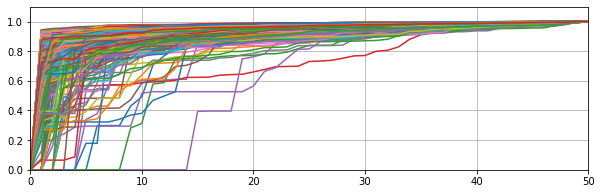

key: (16, 2, 'lab', 10, 50, 0.4)


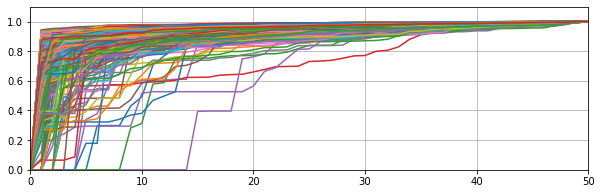

Wall time: 7.23 s


In [259]:
%%time
print('5: plot results')
print(datetime.now())

#samples = 25

for key in distances:
    print('key:', key)
    plt_dat = distances[key]['plt_dat']
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,3))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)
    for k, i in plt_dat.items():
        ax1.plot(i/i[norm_value])
        #ax1.plot(i)
    ax1.grid(True)
    ax1.set_xlim(0, norm_value)
    ax1.set_ylim(0, 1.1)
    plt.show()

## With suited hyper parameter the f1-Score for all-2-all was calculated

### Load data.

In [17]:
%%time
# load prepared data
del all_data
all_data = dict()
all_data[162] = ct.read_dict("all_data_20210425_16.csv",DATA)

params = {'all_data'   : all_data,
          'use'        : 162,
          'index'      : 2,
          'colorspace' : 'lab'}
# call data_prep() to prepare loaded data
pid_lst_all, clr_lst_all, dst_lst_all = data_sort(**params)
dst_lst_all[0][:20]

read: D:/_DataScience/CapstoneProject/ColorMatch/all_data_20210423_16.csv.pickle
Wall time: 5h 10min 48s


In [9]:
save_dist = ct.read_dict("cm_save_dist_store1",DATA)
pid_lst_all, clr_lst_all, dst_lst_all = save_dist['store1']

### Apply hyper parameter for all-2-all (34250x34250) and calculate all distances

In [83]:
%%time
result_ = calc_np_scoring(pid_lst  = pid_lst_all,
                  dst_lst    = dst_lst_all,
                  dict_begin = dict_begin,
                  verbose    = True,
                  show       = 8,
                  stop       = 10,
                  knn_stop   = 10,
                  normalize  = True,
                  threshold  = 0.6,
                  norm_value = 50)


-> 0 train_129225211 /  2 / 249114794 0.4574254059266625 0.6
0.000000 train_129225211    249114794          XX 0.500

-> 1 train_3386243561 /  2 / 2937985045 0.4306537249209836 0.6
0.000000 train_129225211    249114794             0.000

-> 2 train_2288590299 /  2 / 2395904891 0.5294720943984887 0.6
0.000000 train_2288590299   2395904891         XX 0.500

-> 3 train_2406599165 /  2 / 4093212188 0.5541716417527894 0.6
0.000000 train_2406599165   4093212188         XX 0.500

-> 4 train_3369186413 /  2 / 3648931069 0.2335697541104555 0.6
0.000000 train_3369186413   3648931069         XX 0.500

-> 5 train_2464356923 /  3 / 2660605217 0.47024829162366316 0.6
0.000000 train_2464356923   2660605217         XX 0.333

-> 6 train_1802986387 /  7 / 1835033137 0.7898168019771132 0.6
0.000000 train_1802986387   1835033137         XX 0.143

-> 7 train_1806152124 /  2 / 1565741687 0.6145781440527005 0.6
0.000000 train_1806152124   1565741687         XX 0.500

-> 8 train_86570404 /  3 / 2359912463 0.

### Calculate the f1-Score (all)

In [251]:
f1score = list()
stop = 35000
for p, c in result.items():
    
    label_group = dict_begin['dic_posting_id_label_group'][p][0]
    cl_real_i = list(dict_begin['dic_label_group_posting_id'][label_group])
    cl_pred_i = list(c)
    f1score.append(sc.f_score_i(cl_real_i, [e[1] for e in cl_pred_i]))
    if stop < 0:
        break
    stop -= 1
print('f1score', sum(f1score)/len(f1score))

f1score 0.5568827593524094


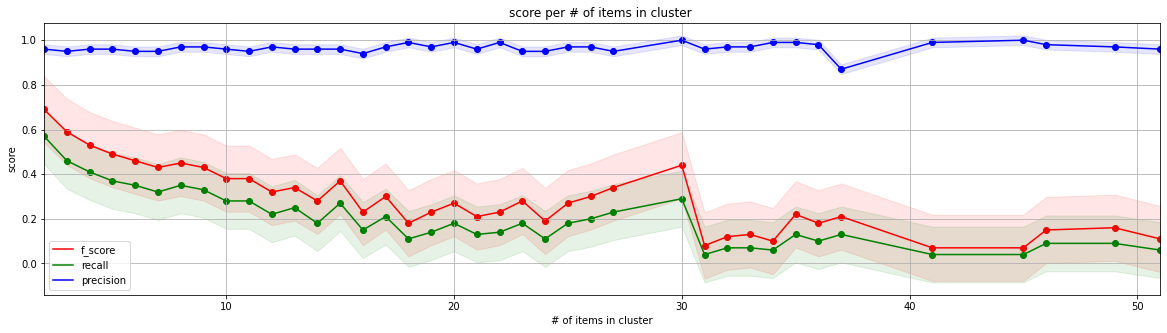

In [47]:
plot_prf_over_no_cl(df_data)

### Calculate the f1-Score (cluster > 1)

In [252]:
result[list(result.keys())[47]]
list(result.keys())[47]
result['train_3697474443']
cluster = dict()
for p, c in result.items():
    if not len(c) in cluster:
        cluster[len(c)] = 0
    cluster[len(c)] += 1
for i in cluster:
    print(i,cluster[i])

1 22434
2 5667
11 469
3 2318
4 1155
5 809
6 451
7 357
8 316
10 119
9 155


In [253]:
f1score = list()
stop = 35000
for p, c in result.items():
    
    label_group = dict_begin['dic_posting_id_label_group'][p][0]
    cl_real_i = list(dict_begin['dic_label_group_posting_id'][label_group])
    cl_pred_i = list(c)
    if len(cl_pred_i) > 1:
        f1score.append(sc.f_score_i(cl_real_i, [e[1] for e in cl_pred_i]))
        if stop < 0:
            break
        stop -= 1
print('f1score', sum(f1score)/len(f1score))

f1score 0.6607993956125231


## Conclusion

The overall **f1-Score** of **0.557** is based on a high **Precision** and a lower **Recall**. This method cannot identify images which are quite different from each other and still belong to the same class of products (aka **label_group**). In the case different means in different in (mean) color and color distribution.

Given a particular image this method often tents to find only the image itself and creates clusters with the size of one (1). The method has a high precision and could may be used with together with other methods.

The method is not very suited to find **all** members of a cluster. Saying that, it is quite good in finding relevant neighbours (aka high **Precision**) but only if the images look similar. That is also the reason why it performs worse in very small clusters. To present any product with two images, these images are often different views or versions of the same item and can not be clustered well with this method.

## Visualize the feature space with PCA and TSNE

To get a better understanding why the algorithm only performs on similar images, ploting the feature hyper space helps to understand.

The features are arranged within a hyper object, similar to what we understand as a sphere. The clusters are blending into each other, therefore a separation of cluster is difficult. 

In [135]:
%%time
all_data = dict()
use        = 16
index      = 1
colorspace = 'lab'

all_data[use] = ct.read_dict("all_data_20210425_16.csv",DATA)
print(all_data[use].keys())

read: D:/_DataScience/CapstoneProject/ColorMatch/all_data_20210425_16.csv.pickle
dict_keys(['16516', '16716', '16516C1', '16516C2'])
Wall time: 5.1 s


In [197]:
keys = list(all_data[use].keys())
print(keys)
df_rgb = all_data[use][keys[index]][0]['rgb'] 
df_hsv = all_data[use][keys[index]][0]['hsv'] 
df_lab = all_data[use][keys[index]][0]['lab'] 

if colorspace == 'lab':
    df = df_lab
    cs = ['lab_l','lab_a','lab_b']
elif colorspace == 'hsv':
    df = df_hsv
    cs = ['hsv_h','hsv_s','hsv_v']
else:
    df = df_rgb
    cs = ['rgb_r','rgb_g','rgb_b']

df_lbl = df['lbl']
df_pid = df['pid']
df_plot = df[cs]  

['16516', '16716', '16516C1', '16516C2']


In [137]:
df_plot.head()

,lab_l,lab_a,lab_b
0,"[0.014492734693877551, 0.01887869387755102, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.023885714285714284, 0.036306285714285715, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [198]:
np_plot = df_plot.to_numpy()    
np_pid = df_pid.to_numpy()
np_lbl = df_lbl.to_numpy()    

In [244]:
samples = 30
lbl_i_rand = list(np.random.randint(34250, size=samples))
#lbl_i_rand

In [245]:
new = np.zeros((34250,500))
count = 0
lbl_new = list()
for i in lbl_i_rand:
    lbl_i = np_lbl[i]
    for j, lbl_c in enumerate(np_lbl):
        if lbl_i == lbl_c:
            #print(lbl_i, lbl_c)
            new[j] = np.concatenate(np_plot[j])
            count += 1
            lbl_new.append(lbl_c)

In [246]:
new = new[:len(lbl_new)]
new.shape, count #, pid_new

((212, 500), 212)

In [247]:
X_pca = PCA(n_components=10, random_state=11).fit_transform(new)
#X_trn = TruncatedSVD(n_components=10, random_state=1).fit_transform(new)
X_tsne = TSNE(n_components=3, perplexity=10, random_state=11, verbose=0).fit_transform(X_pca)
X_tsne.shape

(212, 3)

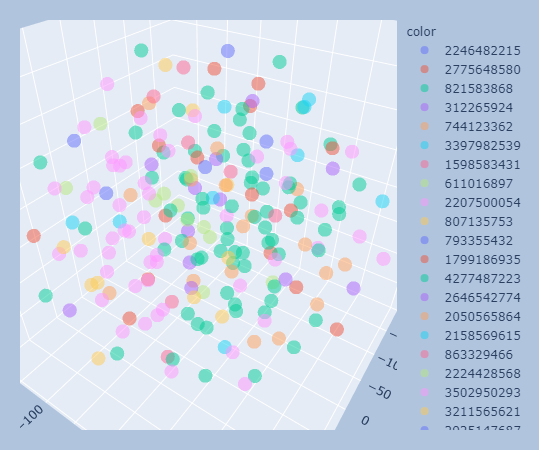

In [248]:
fig = px.scatter_3d(X_tsne, x=0,y=1,z=2, color=lbl_new, size_max=0.001, opacity=0.5)

# tight layout
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="LightSteelBlue")#, showlegend=False)